# Sistemas de Recomendación - Netflix Prize Challenge

En este notebook vamos a implementar un sistema de recomendación a través de un filtro colaborativo.

## 1. Carga de Datos y preparación del Dataset

Vamos a empezar cargando uno de los archivos con calificaciones para explorarlo. Como son archivos grandes y van a ocupar bastante lugar en memoria, no vamos a cargar la última columna con fechas.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector

In [8]:
def load_data(name):
    df = pd.read_csv(name, header = None, names = ['User','Rating'], usecols = [0,1])
    df['Rating'] = df['Rating']
    return df


df1 = load_data('combined_data_1.txt')
print(df1.shape)

(24058263, 2)


In [9]:
df1.head()

,User,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


Para saber a que película corresponde cada calificación contaremos cuántas películas hay en `df1` y las identificaremos. Para ello, cargamos `movie_titles.csv`. Como no nos interesa el año, no lo traemos.

In [10]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


De esta forma, podemos obtener el nombre de una película dado su Id

In [11]:
movie_id = 1
print(df_title.loc[movie_id].Name)

Dinosaur Planet


Para contar cuántos identificadores hay, vamos a usar la siguiente información: al lado del identificador de la película, la columna `Rating` de `df1` tiene un `NaN`.

In [12]:
movies_ids_df1 = df1.User[df1.Rating.isna()].values
print(movies_ids_df1)
print(len(movies_ids_df1))

['1:' '2:' '3:' ... '4497:' '4498:' '4499:']
4499


Si queremos usarlo para pasar de identificador al nombre, debemos llevarlo a enteros. Asumimos que no hay ningun repetido:

In [13]:
movies_ids_df1 = np.arange(1,len(movies_ids_df1) + 1)
print(movies_ids_df1)

[   1    2    3 ... 4497 4498 4499]


### Movie Id

Intentaremos agregar una columna al Dataframe con el Id de la película a la que corresponde la calificación. Para ello, vamos a necesitar saber dónde están ubicados los identificadores.

Primero, seleccionamos los índices donde aparecen los movies_ids

In [14]:
df1_nan = pd.DataFrame(pd.isnull(df1.Rating))
df1_nan = df1_nan[df1_nan['Rating'] == True]
idx_movies_ids = df1_nan.index.values
print(idx_movies_ids)

[       0      548      694 ... 24056849 24057564 24057834]


Queremos crear un vector de tantas instancias como `df1`, donde en cada lugar esté movie_id a cual corresponde la calificación. Como tenemos los índices donde está cada movie_id, podemos obtener cuántas calificaciones hay de cada película.

In [15]:
# Agregamos el indice de la ultima instancia del dataframe
idx_movies_ids = np.append(idx_movies_ids,df1.shape[0])
cantidad_criticas = np.diff(idx_movies_ids)
cantidad_criticas

array([ 548,  146, 2013, ...,  715,  270,  429], dtype=int64)

In [16]:
columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df1[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))

Agregamos esa columna al dataset

In [17]:
df1['movie_id'] = columna_movie_id
del columna_movie_id

df1.dropna(inplace = True)
df1['User'] = df1['User'].astype(int)
df1['movie_id'] = df1['movie_id'].astype(np.int16)
df1['Rating'] = df1['Rating'].astype(np.int8)

gc.collect()

7

In [18]:
df1

,User,Rating,movie_id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1
...,...,...,...
24058258,2591364,2,4499
24058259,1791000,2,4499
24058260,512536,5,4499
24058261,988963,3,4499


Ya contamos con un dataframe con calificaciones de usuarios a películas.

Una opción es guardar el dataset modificado en nuevo archivo y, a partir de ahora, trabajar con esa versión. Esto hará que no tengamos que hacer el preprocesamiento cada vez que empecemos a trabajar y, además, ahorrarnos toda la "basura" que Python pueda ir dejando en la RAM.

In [23]:
df1.to_csv('combined_data_1_con_movie_id.csv', index= False)

## 2. Exploración del Dataset


Arrancamos abriendo el dataset ya modificado:

In [24]:
df1 = pd.read_csv('combined_data_1_con_movie_id.csv', dtype={'Rating': np.int8, 'movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [25]:
df1.dtypes

User        int64
Rating       int8
movie_id    int16
dtype: object

Y los títulos

In [26]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


1. ¿Cuántos usuarios únicos hay?

In [27]:
print(len(df1['User'].unique()))

470758


2. ¿Cuántas películas calificó cada usuario?

In [28]:
df1_by_users = df1.groupby(['User']).count()
df1_by_users.head()

,Rating,movie_id
User,,
6,153,153
7,195,195
8,21,21
10,49,49
25,4,4


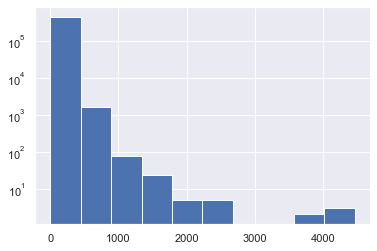

In [29]:
plt.hist(df1_by_users.Rating, log= True)
plt.show()

3. ¿Cómo es la distribución de las calificaciones?

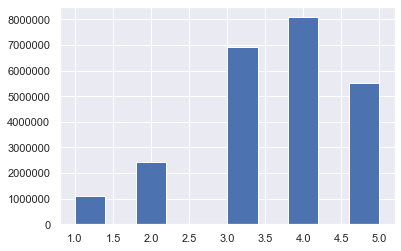

In [30]:
df1['Rating'].hist()
plt.show()

4. ¿Cuál es la película con más calificaciones?¿Cuántas tiene?¿Y la que menos calificaciones tiene?

In [31]:
df1_by_movies = df1.groupby(['movie_id']).count()
df1_by_movies.head()

,User,Rating
movie_id,,
1,547,547
2,145,145
3,2012,2012
4,142,142
5,1140,1140


In [34]:
idx_max = df1_by_movies['User'].idxmax()
print(df_title.loc[idx_max].Name)

Pirates of the Caribbean: The Curse of the Black Pearl


In [35]:
# Pelicula con menos calificaciones
idx_min = df1_by_movies['User'].idxmin()
print(df_title.loc[idx_min].Name)

Bram Stoker's: To Die For


### Extra

Ordenamos las películas por popularidad y le ponemos el nombre

In [36]:
df1_by_movies = df1.groupby(['movie_id']).count()
df1_by_movies.sort_values('User', ascending = False, inplace = True)
df1_by_movies['Vistos'] = df1_by_movies['User']
df1_by_movies.drop(columns = ['User','Rating'], inplace = True)
df1_by_movies.head(10)

,Vistos
movie_id,
1905,193941
2152,162597
3860,160454
4432,156183
571,154832
3938,153996
4306,151292
2452,149866
1962,145519


In [37]:
df1_by_movies['Titulo'] = df_title.loc[df1_by_movies.index].Name
df1_by_movies

,Vistos,Titulo
movie_id,,
1905,193941,Pirates of the Caribbean: The Curse of the Bla...
2152,162597,What Women Want
3860,160454,Bruce Almighty
4432,156183,The Italian Job
571,154832,American Beauty
...,...,...
4294,44,Ghost Hunters: Season 1
915,43,Haven
3656,42,Expo: Magic of the White City


### Filtrarmos películas con pocos ratings

Primero, veamos cómo es la distribución de `Vistos`.

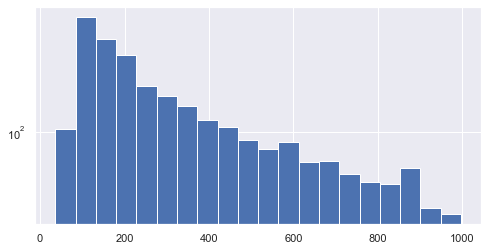

In [41]:
plt.figure(figsize = (8,4))
# df1_by_movies.Vistos.hist(log = True, bins = 50)
df1_by_movies.Vistos[df1_by_movies.Vistos<1000].hist(log = True, bins = 20)
plt.show()

Ahora vamos a elegir un umbral y descartar aquellas películas que tengan menos vistos que ese umbral. Primero, creamos un arreglo con los movies_ids de las películas que queremos descartar.

In [42]:
umbral = 1000
mascara_pocos_vistos = df1_by_movies.Vistos<umbral
peliculas_pocos_vistos = mascara_pocos_vistos[mascara_pocos_vistos].index.values
print(len(peliculas_pocos_vistos), peliculas_pocos_vistos)

2757 [1817  806 3486 ... 3656 4338 4362]


Ahora, tiramos de `df1` aquellas calificaciones que correspondan a las películas que queremos descartar.

In [45]:
mascara_descartables = df1.movie_id.isin(peliculas_pocos_vistos)
mascara_descartables

0           True
1           True
2           True
3           True
4           True
            ... 
24053759    True
24053760    True
24053761    True
24053762    True
24053763    True
Name: movie_id, Length: 24053764, dtype: bool

In [46]:
print(df1.shape)
df1 = df1[~mascara_descartables]
print(df1.shape)

(24053764, 3)
(23163063, 3)


## 3. Entrenamiento

Para entrenar el sistema de recomendación vamos a usar la biblioteca Surprise.

### 3.1 Dataset y Train/test split


In [47]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

In [48]:
reader = Reader()

Creamos el `Dataset` de Surprise usando `Dataset.load_from_df`

In [57]:
N_filas = 250000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(df1[['User', 'movie_id', 'Rating']][:N_filas], reader)

In [58]:
trainset, testset = train_test_split(data, test_size=.25)

### 3.2 Entrenamiento

Vamos a entrenar un algoritmo SVD.

In [59]:
from surprise import SVD
algo = SVD()

Entrenamos sobre el `trainset`

In [60]:
algo.fit(trainset)

Y predecimos sobre el `testset`.

In [61]:
predictions = algo.test(testset)

In [62]:
predictions[1]

Prediction(uid=2577397, iid=30, r_ui=1.0, est=3.800685137841965, details={'was_impossible': False})

En cambio, si queremos predecir para un usuario y una película en particular, usamos la función `predict`

In [63]:
algo.predict(1328945,28)

Prediction(uid=1328945, iid=28, r_ui=None, est=3.55478709301328, details={'was_impossible': False})

Exploremos un usuario, veamos cuáles películas le gustaron y cuáles les recomienda el sistema.


In [64]:
usuario = 1539350
rating = 4   # le pedimos peliculas a las que haya puesto 4 o 5 estrellas
df_user = df1[(df1['User'] == usuario) & (df1['Rating'] >= rating)]
df_user = df_user.reset_index(drop=True)
df_user['Name'] = df_title['Name'].loc[df_user.movie_id].values
df_user

,User,Rating,movie_id,Name
0,1539350,4,111,Duplex (Widescreen)
1,1539350,4,175,Reservoir Dogs
2,1539350,4,197,Taking Lives
3,1539350,5,269,Parenthood
4,1539350,5,270,Sex and the City: Season 4
5,1539350,4,367,Spun
6,1539350,5,406,Hostage
7,1539350,4,457,Kill Bill: Vol. 2
8,1539350,4,692,The Hand that Rocks the Cradle
9,1539350,4,758,Mean Girls


Creamos donde vamos a guardar las recomendaciones

In [65]:
recomendaciones_usuario = df_title.iloc[:4499].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(4499, 1)


,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


Sacamos del dataframe todas las películas que ya sabemos que vio

In [66]:
usuario_vistas = df1[df1['User'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(97, 3)


,User,Rating,movie_id
219870,1539350,3,33
409717,1539350,4,111
445206,1539350,3,127
664099,1539350,4,175
894718,1539350,4,197


In [67]:
if True: # Sacamos las que filtramos (si filtramos)
    recomendaciones_usuario.drop(peliculas_pocos_vistos, inplace = True)
recomendaciones_usuario.drop(usuario_vistas.movie_id, inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,Movie_Id,Name
0,3,Character
1,5,The Rise and Fall of ECW
2,6,Sick
3,8,What the #$*! Do We Know!?
4,16,Screamers


Y hacemos las recomendaciones

In [68]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['Movie_Id'].apply(lambda x: algo.predict(usuario, x).est)

In [69]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
print(recomendaciones_usuario.head(10))

    Movie_Id                                               Name  \
12        32  ABC Primetime: Mel Gibson's The Passion of the...   
13        44                                     Spitfire Grill   
3          8                         What the #$*! Do We Know!?   
20        56                                          Carandiru   
8         25      Inspector Morse 31: Death Is Now My Neighbour   
15        46                     Rudolph the Red-Nosed Reindeer   
6         18                                   Immortal Beloved   
11        30                             Something's Gotta Give   
10        28                                    Lilo and Stitch   
18        52                            The Weather Underground   

    Estimate_Score  
12        4.204415  
13        4.117057  
3         3.830618  
20        3.795983  
8         3.780647  
15        3.779131  
6         3.770260  
11        3.756972  
10        3.735052  
18        3.599095  


### 3.3 Evaluación

Para el conjunto de `testset`, evaluamos el error RMSE entre las predicciones y las verdaderas calificaciones que le habían dado a las películas.

In [70]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 1.0047


1.0046502388667362

### 3.4 Optimización de parámetros



In [71]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(factor)
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9941  0.9924  0.9928  0.9931  0.0007  
Fit time          3.14    2.95    3.22    3.10    0.11    
Test time         0.70    0.48    0.72    0.64    0.11    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9944  0.9935  0.9938  0.9939  0.0004  
Fit time          3.31    4.19    4.23    3.91    0.42    
Test time         1.05    0.67    1.01    0.91    0.17    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9960  0.9959  0.9934  0.9951  0.0012  
Fit time          4.33    4.00    4.07    4.13    0.14    
Test time         0.62    0.61    0.58    0.60    0.02    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9983  0.9

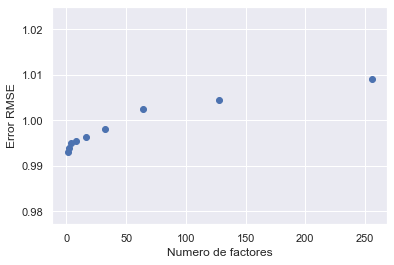

In [72]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [73]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,10],'n_epochs': [10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)


In [74]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9932642187317136
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


## 4. Agrandando el Dataset

Ahora vamos a sumar al dataset el resto de las calificaciones que no usamos.

Como corremos el riesgo de que se nos llene la memoria RAM, vamos a hacerlo de a poco. Arrancamos agregando las calificaciones que hay en `combined_data_2.txt`.

0. Reiniciar el Kernel
1. Abrir el archivo `combined_data_2.txt` con la función `load_data`.
2. Agregar una columna con el movie_id al que corresponde las calificaciones.
3. Abrir el archivo donde ya está procesado `combined_data_1.txt`. 
4. Agregar al final las nuevas calificaciones y guardarlo en un nuevo archivo.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector

In [2]:
def load_data(name):
    df = pd.read_csv(name, header = None, names = ['User','Rating'], usecols = [0,1])
    df['Rating'] = df['Rating']
    return df


df2 = load_data('combined_data_2.txt')
print(df2.shape)

(26982302, 2)


In [3]:
movies_ids_df2 = df2.User[df2.Rating.isna()].values
print(movies_ids_df2)
print(len(movies_ids_df2))

movies_ids_df2 = np.arange(4500,len(movies_ids_df2) + 4500)
print(movies_ids_df2)

['4500:' '4501:' '4502:' ... '9208:' '9209:' '9210:']
4711
[4500 4501 4502 ... 9208 9209 9210]


In [4]:
df2_nan = pd.DataFrame(pd.isnull(df2.Rating))
df2_nan = df2_nan[df2_nan['Rating'] == True]
idx_movies_ids = df2_nan.index.values
print(idx_movies_ids)

[       0      259      855 ... 26961403 26980373 26980497]


In [5]:
# Agregamos el indice de la ultima instancia del dataframe
idx_movies_ids = np.append(idx_movies_ids,df2.shape[0])
cantidad_criticas = np.diff(idx_movies_ids)
cantidad_criticas

array([  259,   596,   105, ..., 18970,   124,  1805], dtype=int64)

In [6]:
columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df2[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))

In [9]:
df2['movie_id'] = columna_movie_id
del columna_movie_id

df2.dropna(inplace = True)
df2['User'] = df2['User'].astype(int)
df2['movie_id'] = df2['movie_id'].astype(np.int16)
df2['Rating'] = df2['Rating'].astype(np.int8)

gc.collect()

147

In [10]:
df2

,User,Rating,movie_id
1,2532865,4,4500
2,573364,3,4500
3,1696725,3,4500
4,1253431,3,4500
5,1265574,2,4500
...,...,...,...
26982297,2420260,1,9210
26982298,761176,3,9210
26982299,459277,3,9210
26982300,2407365,4,9210


In [11]:
df1 = pd.read_csv('combined_data_1_con_movie_id.csv', dtype={'Rating': np.int8, 'movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [12]:
df = df1.copy()
del df1
df = df.append(df2)
print(df.shape)

(51031355, 3)


Chequeamos que estén todas las películas:

In [13]:
peliculas_presentes = df.movie_id.unique()
peliculas_presentes

array([   1,    2,    3, ..., 9208, 9209, 9210], dtype=int64)

In [14]:
print((peliculas_presentes - np.arange(1,9210 + 1)).sum())

0


Y guardamos

In [15]:
df.to_csv('combined_data_1y2_con_movie_id.csv', index= False)

In [16]:
df

,User,Rating,movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1
...,...,...,...
26982297,2420260,1,9210
26982298,761176,3,9210
26982299,459277,3,9210
26982300,2407365,4,9210
